# Chapter 5. 오차역전파법

- 수치 미분을 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸린다는 게 단점.
- 이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계산하는 '오차역전파법'을 배워보려고 합니다

## 5.2 연쇄법칙

- 합성 함수 : 여러 함수로 구성된 함수
- 합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.


## 5.3 역전파
- 덧셈의 역전파에서는 상류의 값을 그대로 흘려보내서 순방향 입력 신호의 값은 필요하지 않음
- 곱셈의 역전파는 순방향 입력 신호의 값을 필요로 해 순방향 입력 신호의 값이 필요함



In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None # 순전파시의 입력 값을 유지하기 위해 사용
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x # 상류에서 넘어온 미분에 순전파 값을 바꿔 곱해서 하류로 흘림
        
        return dx, dy

In [3]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [4]:
apple_price = mul_apple_layer.forward(apple, apple_num)

In [5]:
apple_price

200

In [6]:
price = mul_tax_layer.forward(apple_price, tax)

In [7]:
print(price)

220.00000000000003


In [8]:
# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)

In [9]:
dapple_price

1.1

In [10]:
dtax

200

In [11]:
dapple,dapple_num = mul_apple_layer.backward(dapple_price)

In [12]:
dapple

2.2

In [13]:
dapple_num

110.00000000000001

In [14]:
dtax

200

In [1]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [3]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


# 5.5 활성화 함수 계층 구현하기
### ReLU 함수! 
- if x>0, y=x
- if x<=0, y=0
- 순전파의 입력인 x가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘립니다. 반면 x가 0 이하면 하류로 신호를 보내지 않음!

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

### Sigmoid
- y = 1/(1+exp^(-x))

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(Self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

# 5.6 Affine / Softmax 계층 구현하기
- 행렬의 내적은 기하학에서는 Affine Transformation이라고 합니다! -> 어파인 변환을 수행하는 처리를 Affine 계층이라고 구현합니다


In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

## 5.6.3 softmax-with-loss 계층

In [10]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

# 5.7 오차역전파
- 1단계 [미니배치] : 훈련 데이터 중 일부를 무작위로 가져옵니다. 이 미니배치의 손실 함수 값을 줄이는 것이 목표
- 2단계 [기울기 산출] : 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구합니다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시
- 3단계 [매개변수 갱신] : 가중치 매개변수를 기울기 방향으로 아주 조금 갱신
- 4단계 [반복] : 1-3단계를 반복

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [13]:

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:2.44021061816e-13
b1:9.69523687272e-13
W2:9.12763158784e-13
b2:1.20126131264e-10


# 학습 구현

In [14]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.160583333333 0.1609
0.90315 0.9081
0.920966666667 0.9232
0.9362 0.9369
0.9446 0.9448
0.949366666667 0.9462
0.957166666667 0.9541
0.961133333333 0.9587
0.964966666667 0.9608
0.967883333333 0.9633
0.969983333333 0.9653
0.97075 0.9639
0.973716666667 0.9667
0.976 0.9681
0.97675 0.9691
0.9787 0.9702
0.9789 0.9698


# 6. 학습 관련 기술들
## 6.1 SGD
- 확률적 경사 하강법
- 가장 크게 기울어진 방향으로 가자!
- 지그재그로 계석 이동해 비효율적임 (비등방성)

In [16]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## 6.1.4 모멘텀
- 운동량을 뜻함. 

In [19]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [20]:
# 인스턴스 변수 v가 물체의 속도.
# SGD와 비교하면 지그재그 정도가 덜함

## 6.1.5 AdaGrad
- 각각의 매개 변수에 맞춤형 값을 만들어줌
- 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행
- h : 기존 기울기값을 제곱해 계속 더해줌

In [21]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.key():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 6.1.6 Adam
- 모멘텀 + AdaGrad
- 더 궁금하다면 원 논문을 확인


### SGD, 모멘텀, AdaGrad, Adam 중 어떤 것이 빠르다! 이런 것은 아직 없음. 학습률과 신경망 구조에 따라 결과가 달라짐.
### 다만 일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 떄로는 최종 정확도도 높게 나타남

# 6.2 초기값


- 초기값을 모두 0을 하면 안되는 이유 : 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 떄문에..!
- 은닉층의 활성화값의 분포를 관찰하면 중요한 정보를 얻을 수 있음

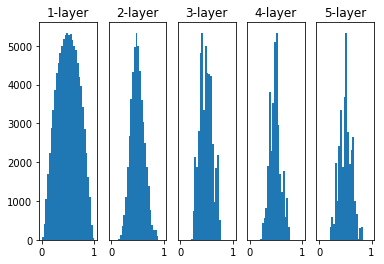

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
#     w = np.random.randn(node_num, node_num) * 1
#     w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [25]:
# (가중치의 표준 편차:1) 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다 사라짐 -> 기울기 소실 (gradient vanishing)
# (가중치의 표준 편차:0.01) 데이터가 0.5 부근에 집중. 치우치는 경우 표현력을 제한하는 관점에서 문제.

### Xaviear 초기값
- 초기값의 표준편차가 1/(루트n) 이 되도록 설정 (n은 앞 층의 노드 수)

# ReLU를 사용할 경우
- ReLU에 특화된 초기값 : He 초기값
- 노드가 n개일 때, 표준편차가 루트2/n인 정규분포를 사용! ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 해석..!

# 간단 정리
- 활성화 함수 ReLU : He 초기값
- 활성화 함수 Sigmoid, tanh등의 S자 곡선 : Xavier 초기값


===========iteration:0===========
std=0.01:2.30250013217
Xavier:2.32583477772
He:2.35230525879
===========iteration:100===========
std=0.01:2.3021881685
Xavier:2.26317348624
He:1.51987125075
===========iteration:200===========
std=0.01:2.30169521978
Xavier:2.14815886623
He:0.764672690242
===========iteration:300===========
std=0.01:2.30276137624
Xavier:1.90363370175
He:0.55631896597
===========iteration:400===========
std=0.01:2.29914678388
Xavier:1.46670421694
He:0.407639640155
===========iteration:500===========
std=0.01:2.30170721926
Xavier:0.950188535012
He:0.351653130484
===========iteration:600===========
std=0.01:2.30113227241
Xavier:0.740427167198
He:0.339266496633
===========iteration:700===========
std=0.01:2.30144413638
Xavier:0.499892023207
He:0.247046717246
===========iteration:800===========
std=0.01:2.29804459384
Xavier:0.469626753554
He:0.254507897572
===========iteration:900===========
std=0.01:2.29292654132
Xavier:0.387462353606
He:0.220948370333
===========iteration:

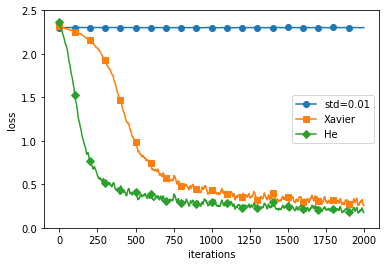

In [27]:
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 6.3 배치 정규화
- 2015년에 제안된 방법
### 배치 정규화가 주목받는 이유
- 학습을 빨리 진행할 수 있음 ( 학습 속도 개선 )
- 초깃값에 크게 의존하지 않음 ( 초깃값 선택 장애 제거 )
- 오버피팅을 억제 ( 드롭아웃 등의 필요성 감소 )


- 학습시 미니배치를 단위로 정규화

# 6.4 바른 학습을 위해
## 오버피팅
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

위 2가지 경우에 일어납니다

훈련 데이터에 최적화되고, 새 데이터가 들어왔을 경우 올바른 값을 내놓지 못합니다

## 6.4.2 가중치 감소
- 큰 가중치에 대해서 그에 상응하는 큰 페널티 부과
### 정규화
1. 릿지 ( 제곱 ) => 설명력이 아쉬운 편
2. 라쏘 ( 절대값 ) => 변수 선택 가능. 중요하지 않은 값은 0으로!

# 6.4.3 드롭아웃
- 뉴런을 임의로 삭제하면서 학습하는 방법

# 6.5 하이퍼 파라미터 튜닝
- 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 막소등을 하이퍼 파라미터라고 칭합니다
- 훈련 데이터 + 시험 데이터에서 검증 데이터까지 추가!


- 훈련 데이터 : 매개변수 학습
- 검증 데이터 : 하이퍼파라미터 성능 평가
- 시험 데이터 : 신경망의 범용 성능 평가

- 신경망의 하이퍼 파라미터 최적화는 그리드 서치같은 규칙적 탐색보다 무작위 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려짐
- 베이즈 최적화란 것도 있으니 참고

# 7. 합성곱 신경망 (CNN)
- 기존에 본 Affine 계층 : 인접하는 계층의 모든 뉴런과 결합된 형태로 **완전연결**이라고 합니다
- 완전연결 신경망은 데이터의 형상이 무시됩니다..!
- **합성곱 계층**은 형상을 유지합니다. 이미지도 3차원 데이터로 입력 받으며 다음 계층에도 3차원으로 전달합니다

#### 기본 용어
- 특징 맵 ( feature map ) : 입출력 데이터
- 입력 특징 맵 : 입력 데이터 / 출력 특징 맵 : 출력 데이터
- 필터(커널)
- 윈도우 : 간격

- 패딩(padding) : 입력 데이터 주변을 특정 값(예를 들어 0) 으로 채움. => 출력 크기를 조정할 목적으로 사용! ( 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있음)
- 스트라이드(stride) : 필터를 적용하는 위치의 간격


- 입력 크기 : (H,W), 필터 크기 : (FH, FW), 출력 크기 : (OH,OW), 패딩 : P, 스트라이드 : S일 경우
- OH = (H+2P-FH)/S + 1
- OW = (W+2P-FW)/S +1

### 풀링 계층
- 풀링 : 세로, 가로 방향의 공간을 줄이는 연산
- 최대 풀링(max pooling) : 영역에서 가장 큰 원소 하나를 꺼냄
- 풀링 계층은 학습해야 할 매개변수가 없음! ( 대상 영역에서 최대값이나 평균을 취할뿐 )
- 채널 수가 변하지 않음!
- 입럭의 변화에 영향을 적게 받음 ( 강건함 )

#### 4차원 배열
- cnn에서 계층 사이를 흐르는 데이터는 4차원입니다. 형사이 (10, 1, 28, 28)이라면 높이 28, 너비 28, 채널 1개인 데이터가 10개라는 이야기입니다!


In [1]:
import numpy as np

In [2]:
x = np.random.rand(10, 1, 28, 28)

In [3]:
x.shape

(10, 1, 28, 28)

In [4]:
# 10개중 첫번째 데이터에 접근할 경우
x[0].shape # (1, 28, 28)

(1, 28, 28)

In [6]:
x[1].shape

(1, 28, 28)

In [7]:
# 첫 데이터의 첫 채널 공간에 접근할 경우
x[0, 0] # 또는 x[0][0]

array([[ 0.09211   ,  0.88611347,  0.03338694,  0.11837624,  0.85346941,
         0.82445568,  0.67712597,  0.75344537,  0.41279763,  0.9786374 ,
         0.06177778,  0.54654415,  0.70927364,  0.81731501,  0.32906787,
         0.91914508,  0.84191272,  0.94901348,  0.69158681,  0.68817398,
         0.30451515,  0.76329848,  0.26899127,  0.18918015,  0.25294696,
         0.58280302,  0.0698739 ,  0.11434238],
       [ 0.3622673 ,  0.1306698 ,  0.43508386,  0.96641739,  0.05746673,
         0.15057794,  0.57228972,  0.09908588,  0.90933671,  0.14057865,
         0.99178052,  0.78921387,  0.69225798,  0.44209711,  0.1254271 ,
         0.38730976,  0.2373709 ,  0.95123871,  0.98739262,  0.96888392,
         0.0534259 ,  0.14521333,  0.61110983,  0.43947422,  0.62318854,
         0.07193239,  0.62506054,  0.67097061],
       [ 0.22025308,  0.32825662,  0.28196533,  0.07340701,  0.4125856 ,
         0.78048303,  0.14739731,  0.43066468,  0.10117215,  0.39310761,
         0.41029203,  0.1369

### 7.4.2 im2col로 데이터 전개하기
- numpy에서는 for문을 사용하지 않는 것이 바람직하기에 im2col이라는 편의 함수를 구현! 
- 메모리를 더 많이 소비하는 단점이 있음..!

In [8]:
from common.util import im2col

In [9]:
# input_data : (데이터 수, 채널 수, 높이, 너비)
# filter_h - 필터의 높이
# filter_w - 필터의 너비
# stride - 스트라이드
# pad - 패딩

In [10]:
import sys, os
sys.path.append(os.pardir)

In [11]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)

In [12]:
print(col1.shape)

(9, 75)


In [13]:
x2 = np.random.rand(10, 3, 7, 7)

In [14]:
col2 = im2col(x2, 5, 5, stride=1, pad=0)

In [15]:
print(col2.shape)

(90, 75)


In [16]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [17]:
# reshape에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶어줌!

In [18]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + ( H - self.pool_h) / self.stride )
        out_w = int(1 + ( W - self.pool_w) / self.stride )
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3,1,2)
        
        return out

In [21]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


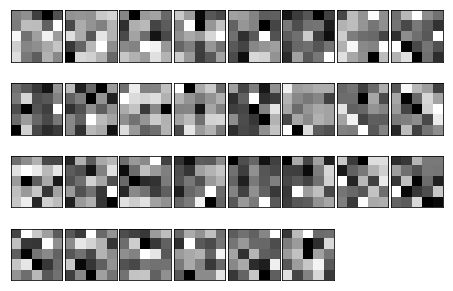

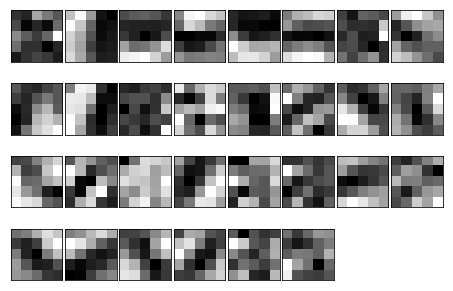

In [28]:

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

import numpy as np
import matplotlib.pyplot as plt
# from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])